In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip uninstall tensorflow -y
    !pip install tensorflow==2.3.1 tensorflow-quantum neptune-client
    !rm -rf quantum-gans
    !git clone https://github.com/WiktorJ/quantum-gans
    !cd quantum-gans; pip install .
    neptun_token = "" # put manually for the time being
else:
    import subprocess
    def get_var(varname):
        CMD = 'echo $(source ~/.bash_profile; echo $%s)' % varname
        p = subprocess.Popen(CMD, stdout=subprocess.PIPE, shell=True, executable='/bin/bash')
        return p.stdout.readlines()[0].strip()
    neptun_token = get_var('NEPTUNE_API_TOKEN').decode("utf-8") 

In [ ]:
%load_ext autoreload
%autoreload 2

In [211]:
use_neptune = False

In [717]:
import neptune
import tensorflow as tf

import io
import cirq
import numpy as np
from qsgenerator import circuits
from qsgenerator.quwgans import circuits as quwgans_circuits
from qsgenerator.quwgans.training import Trainer
from qsgenerator.phase.circuits import PhaseCircuitBuilder
from qsgenerator.states.butterfly_circuits import ButterflyCircuitBuilder
from qsgenerator.states.simple_rotation_generators import get_fixed_random_rotation_provider
from qsgenerator.evaluators.circuit_evaluator import CircuitEvaluator
from qsgenerator.phase.analitical import get_theta_v, get_theta_w, get_theta_r, get_g_parameters_provider


In [718]:
generator_layers = 3
data_bus_size = 6
rank = 1

In [719]:
real_circuit_type = 'butterfly'
generic_generator = True
zxz = False
all_gates_parametrized = False

In [720]:
data_qubits = qubits = cirq.GridQubit.rect(1, data_bus_size)

In [728]:
if real_circuit_type == 'butterfly':
    real, real_symbols = ButterflyCircuitBuilder().build(qubits=qubits)
    real_values_provider = get_fixed_random_rotation_provider(len(real_symbols))
else:
    builder = PhaseCircuitBuilder(all_gates_parametrized=False)
    real, real_symbols, symbols_dict_real = builder.build_ground_state_circuit(qubits=data_qubits)
    real_values_provider = get_g_parameters_provider()

In [705]:
pauli_strings, qubit_to_string_index = quwgans_circuits.get_discriminator(real)

In [736]:
if generic_generator:
    gen, gs = circuits.build_circuit(generator_layers, data_qubits, "g")
    symbols_dict_gen = {}
else:
    builder = PhaseCircuitBuilder(all_gates_parametrized=all_gates_parametrized)
    gen, gs, symbols_dict_gen = builder.build_ground_state_circuit(qubits=data_qubits, full_parametrization=True, zxz=zxz)

In [723]:
print("REAL GROUND STATE")
real

REAL GROUND STATE


┌──────────────────┐                 ┌───────────────────────────┐
(0, 0): ───Rx(theta0)───@──────────Rx(theta9)─────@─────────────────────Rx(theta17)────@──────────────────────────────
                        │                         │                                    │
(0, 1): ───Rx(theta1)───X^theta6───Rx(theta10)────┼────────@────────────Rx(theta18)────┼────────@─────────────────────
                                                  │        │                           │        │
(0, 2): ───Rx(theta2)───@──────────Rx(theta11)────X^theta15┼────────────Rx(theta19)────┼────────┼────────@────────────
                        │                                  │                           │        │        │
(0, 3): ───Rx(theta3)───X^theta7───Rx(theta12)─────────────X^theta16────Rx(theta20)────X^theta23┼────────┼────────────
                                                                                                │        │
(0, 4): ───Rx(theta4)───@──────────Rx(theta13)──────────────────────────Rx(theta21)─────────────X^theta24┼────────────
                        │                                                                                │
(0, 5): ───Rx(theta5)───X^theta8───Rx(theta14)──────────────────────────Rx(theta22)──────────────────────X^theta25────
                                                 └──────────────────┘                 └───────────────────────────┘

In [724]:
print("GENERATOR")
gen

GENERATOR


(0, 0): ───Rx(g0)───Rz(g6)────ZZ────────────────Rx(g17)───Rz(g23)───ZZ────────────────Rx(g34)───Rz(g40)───ZZ────────────────
                              │                                     │                                     │
(0, 1): ───Rx(g1)───Rz(g7)────ZZ^g12───ZZ───────Rx(g18)───Rz(g24)───ZZ^g29───ZZ───────Rx(g35)───Rz(g41)───ZZ^g46───ZZ───────
                                       │                                     │                                     │
(0, 2): ───Rx(g2)───Rz(g8)────ZZ───────ZZ^g15───Rx(g19)───Rz(g25)───ZZ───────ZZ^g32───Rx(g36)───Rz(g42)───ZZ───────ZZ^g49───
                              │                                     │                                     │
(0, 3): ───Rx(g3)───Rz(g9)────ZZ^g13───ZZ───────Rx(g20)───Rz(g26)───ZZ^g30───ZZ───────Rx(g37)───Rz(g43)───ZZ^g47───ZZ───────
                                       │                                     │                                     │
(0, 4): ───Rx(g4)───Rz(g10)───ZZ───────ZZ^g16───Rx(g21)───Rz(g27)───ZZ───────ZZ^g33───Rx(g38)───Rz(g44)───ZZ───────ZZ^g50───
                              │                                     │                                     │
(0, 5): ───Rx(g5)───Rz(g11)───ZZ^g14────────────Rx(g22)───Rz(g28)───ZZ^g31────────────Rx(g39)───Rz(g45)───ZZ^g48────────────

In [735]:
g_values = [-0.8]

In [726]:
opt = tf.keras.optimizers.Adam(0.01, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [737]:
trainer = Trainer(real, 
                  real_symbols,
                  gen,
                  gs,
                  g_values,
                  real_values_provider,
                  rank=rank,
                  use_neptune=use_neptune)

In [738]:
epochs = 501
gen_iteration = 1
snapshot_interval_epochs = 100

In [739]:
if use_neptune:
    neptune.init(project_qualified_name='wiktor.jurasz/thesis-em', api_token=neptun_token)
    neptun_params = {
        'generator_layers': generator_layers,
        'size':  data_bus_size,
        'rank': rank,
        'real_circuit_type': real_circuit_type,
        'generic_generator': generic_generator,
        'zxz': zxz,
        'all_gates_parametrized': all_gates_parametrized,
        'g_values': g_values,
        'gen_iteration': gen_iteration,
        'epochs': epochs
    }
    neptune.create_experiment(name=None, description=None, params=neptun_params)
    neptune.log_artifact(io.StringIO(str(gen)), "gen.txt")
    neptune.log_artifact(io.StringIO(str(([(el[0].numpy(), el[1], list(el[2].numpy())) for el in trainer.gen_weights]))), 'init_gen_weights.txt')

<Figure size 432x288 with 0 Axes>

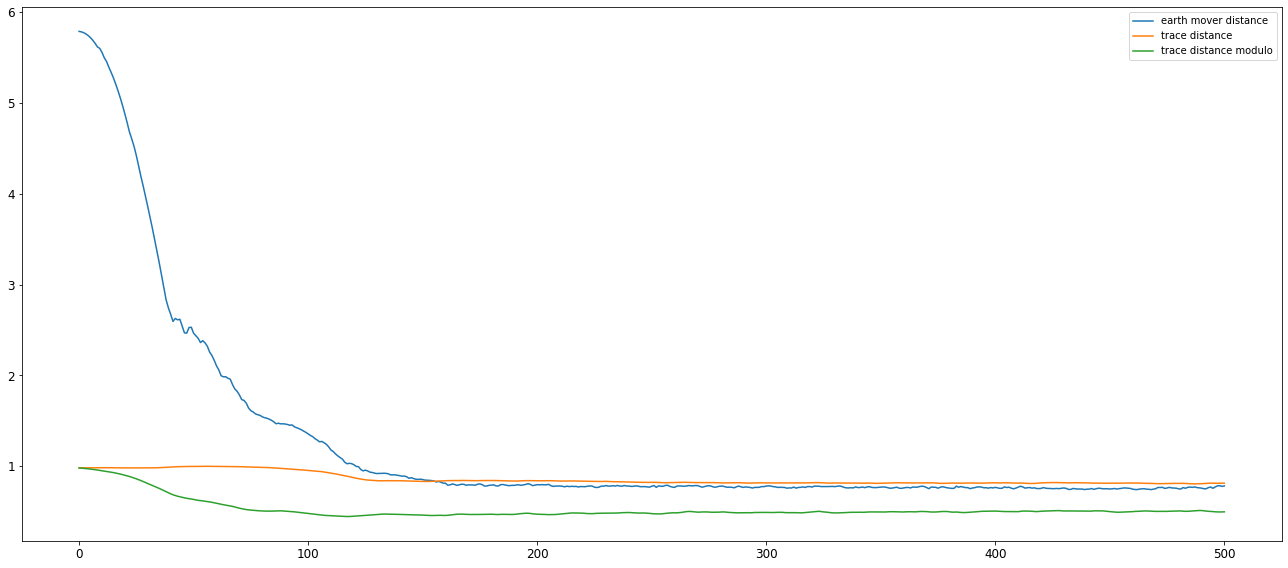

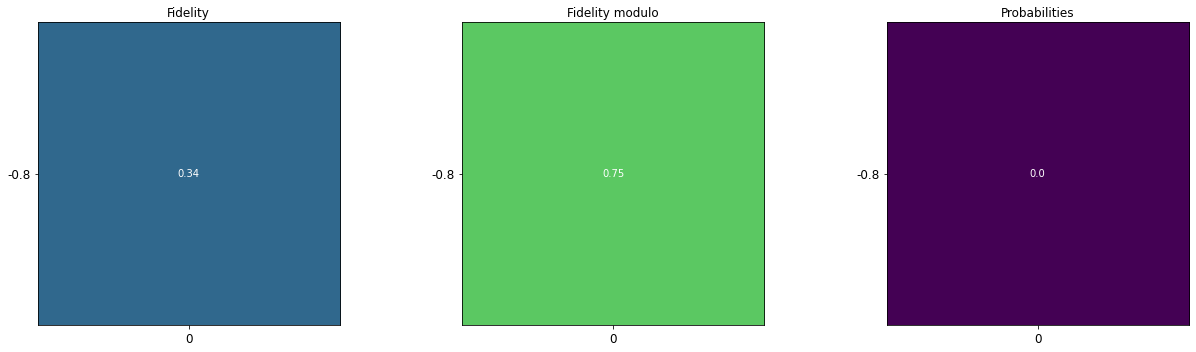

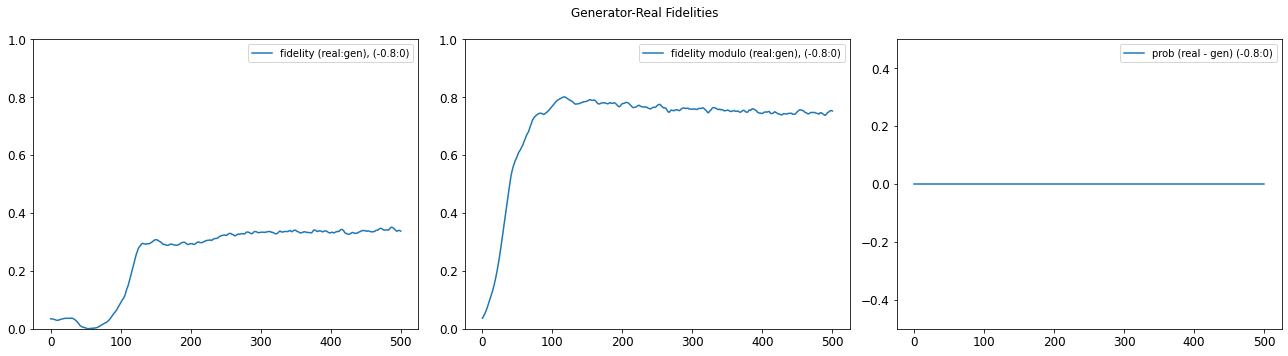

----------------------------------------------------
Epoch 500:  EM distance = 0.7835342736692491, trace distance = 0.8140969246388654, abs trace distance = 0.4978313023759768
h=Y((0, 0))*Y((0, 2)), w=0.9999999800987445, e=0.32302865386009216
h=X((0, 3))*Z((0, 4)), w=0.49999999262250455, e=0.32625535130500793
h=Y((0, 4))*Z((0, 5)), w=0.49999999257648164, e=0.29594552516937256
h=X((0, 3))*X((0, 5)), w=0.499999987602363, e=0.2988103926181793
-------------------------------------
----------- TRAINING DONE -----------


In [740]:
json_result = trainer.train(opt, epochs, gen_iteration, snapshot_interval_epochs, plot=True)

<Figure size 432x288 with 0 Axes>

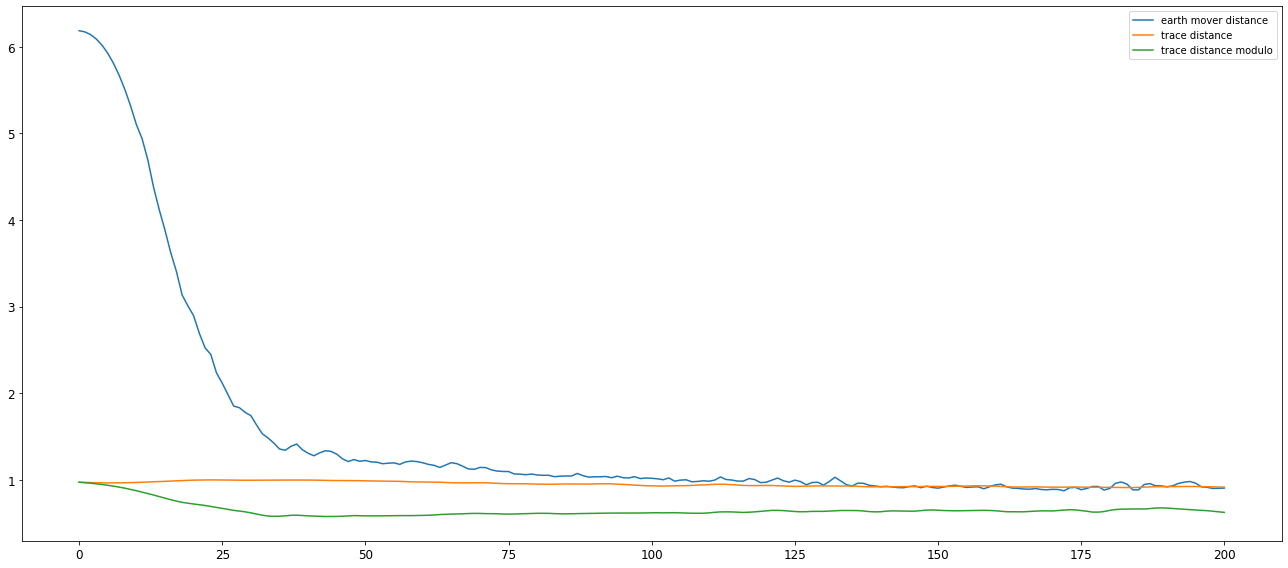

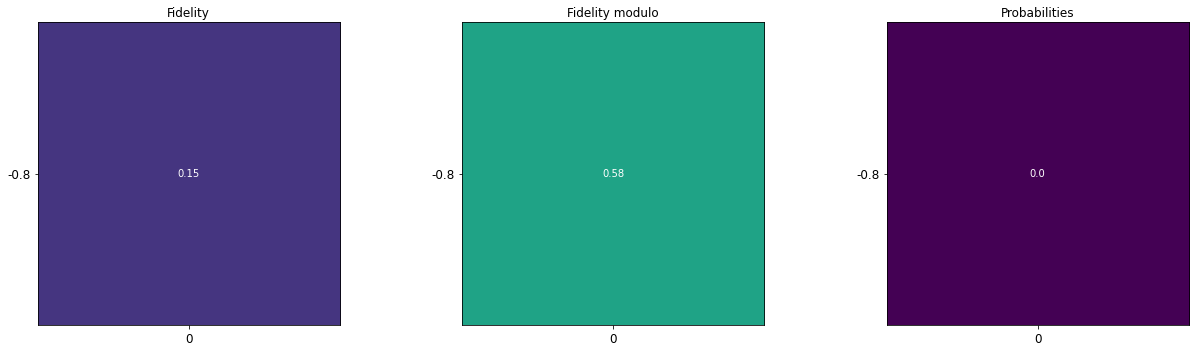

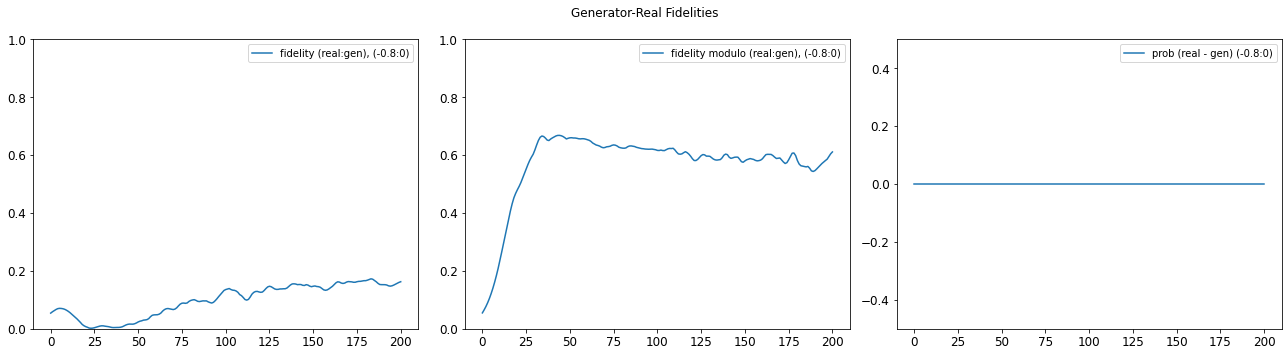

----------------------------------------------------
Epoch 200:  EM distance = 0.9046167726075707, trace distance = 0.9151246284951599, abs trace distance = 0.623919407640758
h=Y((0, 2))*X((0, 5)), w=0.9999999994174148, e=0.43657514452934265
h=Y((0, 1))*X((0, 4)), w=0.9999999994844782, e=0.35149118304252625
h=X((0, 0))*Y((0, 3)), w=0.999999999267311, e=0.11655044555664062


In [ ]:
# g_values = [-0.5, -0.5, -0.5, -0.5, -0.5, -0.4, -0.4, -0.4, -0.4, -0.4]
g = -0.8
sizes = [3,4,5,6,7,8]
epochs = 801
gen_iteration = 2
snapshot_interval_epochs = 200
rank = 1
res = {}
g_dict = {}
for i, s in enumerate(sizes):
    data_qubits = qubits = cirq.GridQubit.rect(1, s)
    
    if real_circuit_type == 'butterfly':
        real, real_symbols = ButterflyCircuitBuilder().build(qubits=qubits)
        real_values_provider = get_fixed_random_rotation_provider(len(real_symbols))
    else:
        builder = PhaseCircuitBuilder(all_gates_parametrized=False)
        real, real_symbols, symbols_dict_real = builder.build_ground_state_circuit(qubits=data_qubits)
        real_values_provider = get_g_parameters_provider()
    
    if generic_generator:
        gen, gs = circuits.build_circuit(generator_layers, data_qubits, "g")
        symbols_dict_gen = {}
    else:
        builder = PhaseCircuitBuilder(all_gates_parametrized=all_gates_parametrized)
        gen, gs, symbols_dict_gen = builder.build_ground_state_circuit(qubits=data_qubits, full_parametrization=True, zxz=zxz)
    
    g_dict[(i, s)] = Trainer(real, real_symbols, gen, gs, [g], real_values_provider, rank=rank, use_neptune=False)
    opt = tf.keras.optimizers.Adam(0.01, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
    json_result = g_dict[(i, s)].train(opt, epochs, gen_iteration, snapshot_interval_epochs, plot=True)
    res[(i,s)] = json_result
    

In [376]:
from scipy.optimize import linprog
def get_em_distance(W, H, t):
    traces = (t.get_all_generator_expectations(H).numpy() - t.get_real_expectation(H).numpy()).flatten()
    return sum(x * y for x, y in zip(W, traces))

def get_em_distance_real(t1, t2):
    traces = (t1.get_real_expectation(t1.disc_hamiltonians).numpy() - t2.get_real_expectation(t2.disc_hamiltonians).numpy()).flatten()
    res = linprog(-traces, A_ub=t.A, b_ub=t.b, bounds=(0, 1))
    tt = [traces[i] for i in range(len(t.disc_hamiltonians)) if res.x[i] > 1.e-5]
    res2 = [res.x[i] for i in range(len(res.x)) if res.x[i] > 1.e-5]
    return sum(x * y for x, y in zip(res2, tt))

def get_em_distance2(W, H, t):
    traces = (t.get_all_generator_expectations(t.disc_hamiltonians).numpy() -
              t.get_real_expectation(t.disc_hamiltonians).numpy()).flatten()
    res = linprog(-traces, A_ub=t.A, b_ub=t.b, bounds=(0, 1))
    tt = [traces[i] for i in range(len(t.disc_hamiltonians)) if res.x[i] > 1.e-5]
    res2 = [res.x[i] for i in range(len(res.x)) if res.x[i] > 1.e-5] 
    return sum(x * y for x, y in zip(res2, tt)), res2, tt

In [384]:
# g=-0.4
# W, H = list(zip(*g_dict[g].last_run_generator_weights[-1].disc_w_h.items()))
# get_em_distance(W, H, g_dict[-0.5]), g_dict[g].last_run_generator_weights[-1].em_distance
g_values2 = [np.round(el, 1) for el in np.linspace(-1,0,11)]
tr = {}
for g in g_values2:
    tr[g] = Trainer(real, real_symbols, gen, gs, [g], real_values_provider, rank=rank, use_neptune=False)


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))
x = g_values2
for g1 in g_values2:
    tmp_res = []
    for g2 in g_values2:
        tmp_res.append(get_em_distance_real(tr[g1], tr[g2]))
    axes.plot(x, tmp_res,label=g1)
axes.legend()
plt.show()

In [514]:
r = defaultdict(lambda: defaultdict(list))
rg = defaultdict(lambda: defaultdict(list))
for i, g in enumerate(sizes):
    print(i, g, g_dict[(i, g)].last_run_generator_weights[-1].fidelities[0].abs_fidelity)
    print({str(v): k for k,v in g_dict[(i, g)].last_run_generator_weights[-1].disc_w_h.items()})
    print()
    for k,v in g_dict[(i, g)].last_run_generator_weights[-1].disc_w_h.items():
        r[g][str(v)].append(i)
        r["N"][str(v)].append(i)
        if g_dict[(i, g)].last_run_generator_weights[-1].trace_distance > 0.9:
            rg[g][str(v)].append(i)
r,rg

0 3 0.9909340327285463
{'Y((0, 1))*X((0, 2))': 0.9999999845336595}

1 4 0.9889339498010976
{'Y((0, 0))*Y((0, 3))': 0.9999997717796357, 'Z((0, 1))*X((0, 2))': 0.9999999581938497}

2 5 0.6386413735106125
{'Z((0, 0))*X((0, 2))': 0.999999774462053, 'X((0, 1))*Y((0, 4))': 0.9999999948819773, 'Z((0, 3))': 0.9999999876550948}

3 6 0.9786873903326665
{'Y((0, 0))*X((0, 2))': 0.9999999981622296, 'X((0, 4))*Y((0, 5))': 0.9999999997945865, 'X((0, 1))*Y((0, 3))': 0.9999999989547431}

4 7 0.9885891241211198
{'Z((0, 2))*Y((0, 3))': 0.9999999698982628, 'X((0, 1))*Z((0, 4))': 0.9999999484039793, 'Y((0, 0))*Y((0, 6))': 0.99999999024243, 'Y((0, 5))': 0.9999999588424817}

5 8 0.8778890931725982
{'Y((0, 2))*Z((0, 6))': 0.9999991956890947, 'Y((0, 4))*Z((0, 5))': 0.999999983515406, 'X((0, 1))*Y((0, 3))': 0.9999999854855334, 'Z((0, 0))*Y((0, 7))': 0.9999999849104662}



(defaultdict(<function __main__.<lambda>()>,
             {3: defaultdict(list, {'Y((0, 1))*X((0, 2))': [0]}),
              'N': defaultdict(list,
                          {'Y((0, 1))*X((0, 2))': [0],
                           'Y((0, 0))*Y((0, 3))': [1],
                           'Z((0, 1))*X((0, 2))': [1],
                           'Z((0, 0))*X((0, 2))': [2],
                           'X((0, 1))*Y((0, 4))': [2],
                           'Z((0, 3))': [2],
                           'Y((0, 0))*X((0, 2))': [3],
                           'X((0, 4))*Y((0, 5))': [3],
                           'X((0, 1))*Y((0, 3))': [3, 5],
                           'Z((0, 2))*Y((0, 3))': [4],
                           'X((0, 1))*Z((0, 4))': [4],
                           'Y((0, 0))*Y((0, 6))': [4],
                           'Y((0, 5))': [4],
                           'Y((0, 2))*Z((0, 6))': [5],
                           'Y((0, 4))*Z((0, 5))': [5],
                           'Z((0, 0))*Y((0, 

In [ ]:
def get_all_states_and_fidelty_for_real(gen_evaluator, 
                                    real_evaluator,
                                    g, 
                                    size):
    generated = gen_evaluator.get_all_states_from_params()
    real = real_evaluator.get_all_states_from_params()
    
    return generated, real, 

In [ ]:
gen_evaluator = trainer.gen_evaluator
real_evaluator = trainer.real_evaluator

In [ ]:
gen_evaluator.get_all_states_from_params()

In [ ]:
real_evaluator.get_all_states_from_params()

In [ ]:
if use_neptune:
    neptune.stop()

In [502]:
def get_expectations_real(g, t):
    full_weights = tf.keras.layers.Layer()(
                tf.Variable(np.array(t.real_values_provider(g), dtype=np.float32)))
    full_weights = tf.reshape(full_weights, (1, full_weights.shape[0]))
    exps = t.real_expectation([t.real],
                                         symbol_names=t.real_symbols,
                                         symbol_values=full_weights,
                                         operators=t.disc_hamiltonians)
    return {h: e for e, h in zip(exps.numpy()[0], [str(h) for h in t.disc_hamiltonians])}
#     return np.array(list(zip(exps.numpy()[0], [str(h) for h in t.disc_hamiltonians])))

def get_expectations_gen(g, t):
    full_weights = tf.keras.layers.Layer()(t.gen_weights[0][2])
    full_weights = tf.reshape(full_weights, (1, full_weights.shape[0]))
    exps = t.gen_expectation([t.gen],
                                         symbol_names=t.gs,
                                         symbol_values=full_weights,
                                         operators=t.disc_hamiltonians)
    return {h: e for e, h in zip(exps.numpy()[0], [str(h) for h in t.disc_hamiltonians])}
    

In [503]:
np.set_printoptions(suppress=True)
def get_exp_diff(g1, g2, eps=1e-2):
    f = [abs(float(e1[1]) - float(e2[1])) > eps for e1, e2 in zip(get_expectations_real(g1, trainer).items(), get_expectations_real(g2, trainer).items())]
    return get_expectations_real(g1, trainer)[f], get_expectations_real(g2, trainer)[f]




In [504]:
from collections import defaultdict

def get_exps(gs, eps=1e-3):
    res = defaultdict(list)
    for g in gs:
        for e in (fe for fe in get_expectations_real(g, trainer).items() if abs(float(fe[1])) > eps):
            res[e[0]].append(e[1])
    return res

def get_exp(g):
    res = defaultdict(list)
    for e in (fe for fe in get_expectations_real(g, trainer).items()):
        res[e[0]].append(e[1])
    return res

In [505]:
from matplotlib import pyplot as plt
import random

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))
gs = [0,-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,-1]
# random.shuffle(gs)
es = get_exps(gs)
res = []
for k, v in es.items():
    c = []
    for i in range(len(v)):
#         c.append(abs(float(v[i]) - float(v[i+1])))
          c.append(float(v[i]))
    res.append(c)
    x = list(range(len(c)))
    axes.plot(x, c,label=k)
axes.legend()
plt.show()
get_exps(gs)

[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0]


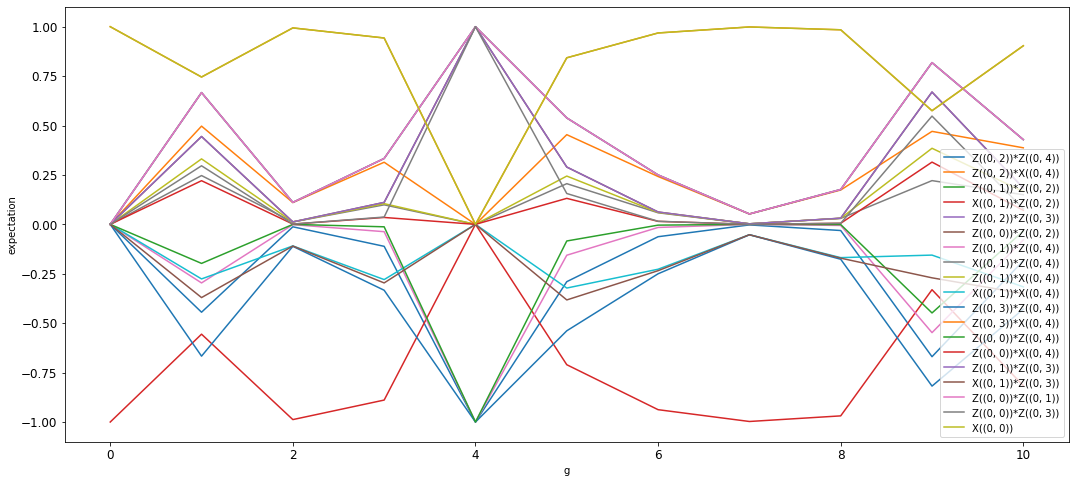

In [507]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))
gs = [np.round(el, 3) for el in np.linspace(-1,0,11)]
print(gs)
random.shuffle(gs)
eps = 1.e-5
res = defaultdict(list)
for g in gs:
    exps = get_exp(g)
    for pauli_string, exp in exps.items():
        res[pauli_string].append(float(exp[0]))
curated_res = {k: v for k, v in res.items() if any(abs(el) > eps for el in res[k])}
for pauli_string, exp in curated_res.items():
    axes.plot(range(len(gs)), exp,label=pauli_string)
axes.legend()
axes.set_xlabel("g")
axes.set_ylabel("expectation")
plt.show()    

In [515]:
states = []
size_to_exps_real = {}
size_to_exps_gen = {}
g = -0.8
eps = 1.e-5
for i, s in enumerate(sizes):
    tr = g_dict[(i, s)] 
    size_to_exps_real[s] = get_expectations_real(g, tr)
    size_to_exps_gen[s] = get_expectations_gen(g, tr)
    states.append(tr.gen_evaluator.get_all_resolved_circuits()[0][2])
string_to_exp = defaultdict(list)
for s, exps_real in size_to_exps_real.items():
    exps_gen = size_to_exps_gen[s]
    for pauli_string, exp_real in exps_real.items():
        exp_gen = exps_gen[pauli_string]
        string_to_exp[pauli_string].append((exp_real, exp_gen))
curated_string_to_exp = {k: v for k, v in string_to_exp.items() if any(abs(float(el[0])) > eps for el in string_to_exp[k])}

In [516]:
curated_string_to_exp

{'Z((0, 0))*Z((0, 2))': [(-0.012345627, 0.0005291179),
  (0.012345634, 0.00023828447),
  (0.012345634, -0.024452768),
  (0.012345627, 0.0013416037),
  (0.012345629, 0.005736038),
  (0.0123456195, 0.021556303)],
 'Z((0, 0))*X((0, 2))': [(0.11042384, 0.020690799),
  (-6.7055225e-08, 0.00050974265),
  (-7.0780516e-08, 0.011134879),
  (-5.2154064e-08, 0.00028579496),
  (-6.7055225e-08, -0.00017764792),
  (-6.7055225e-08, 0.0005356199)],
 'Z((0, 0))*Z((0, 1))': [(0.11111183, 0.020498537),
  (0.111111864, 0.020499364),
  (0.11111187, 0.077108815),
  (0.11111188, 0.025436752),
  (0.11111187, 0.027179666),
  (0.11111189, 0.109225295)],
 'Y((0, 1))*Y((0, 2))': [(0.993808, -0.9933382),
  (5.9977174e-07, -0.07030222),
  (6.1653554e-07, -0.047032382),
  (6.146729e-07, 0.024587084),
  (6.314367e-07, 0.0026703924),
  (6.221235e-07, 0.012251001)],
 'Z((0, 1))*Z((0, 2))': [(-0.111109965, -0.08970877),
  (0.111109935, 0.0017788969),
  (0.11110995, 0.04966813),
  (0.11110998, 0.028225299),
  (0.11110999

In [518]:
states[0]

(0, 0): ───Rx(0.223π)────Rz(0.183π)────ZZ─────────────────────Rx(0.2π)──────Rz(0.194π)────ZZ────────────────────Rx(0.151π)───Rz(0.199π)───ZZ─────────────────────
                                       │                                                  │                                               │
(0, 1): ───Rx(-0.076π)───Rz(-0.008π)───ZZ^-0.22───ZZ──────────Rx(-0.227π)───Rz(-0.055π)───ZZ^0.027───ZZ─────────Rx(-0.25π)───Rz(0.031π)───ZZ^-0.017───ZZ─────────
                                                  │                                                  │                                                │
(0, 2): ───Rx(0.157π)────Rz(-0.14π)───────────────ZZ^-0.056───Rx(0.194π)────Rz(-0.149π)──────────────ZZ^0.095───Rx(0.2π)─────Rz(0.169π)───────────────ZZ^(4/9)───

In [523]:
states[1]

(0, 0): ───Rx(0.154π)───Rz(0.072π)────ZZ─────────────────────Rx(0.18π)────Rz(0.125π)────ZZ──────────────────────Rx(0.24π)────Rz(0.227π)───ZZ───────────────────────
                                      │                                                 │                                                 │
(0, 1): ───Rx(0.039π)───Rz(0.013π)────ZZ^(-1/16)───ZZ────────Rx(0.17π)────Rz(-0.055π)───ZZ^0.06────ZZ───────────Rx(0.316π)───Rz(0.034π)───ZZ^(-1/11)───ZZ──────────
                                                   │                                               │                                                   │
(0, 2): ───Rx(0.185π)───Rz(-0.019π)───ZZ───────────ZZ^0.16───Rx(0.196π)───Rz(-0.089π)───ZZ─────────ZZ^(-1/13)───Rx(0.127π)───Rz(0.622π)───ZZ───────────ZZ^-0.463───
                                      │                                                 │                                                 │
(0, 3): ───Rx(0.072π)───Rz(-0.105π)───ZZ^(-1/13)─────────────Rx(0.168π)───Rz(-0.116π)───ZZ^0.146────────────────Rx(0.279π)───Rz(0.074π)───ZZ^0.398─────────────────

In [532]:
gen4_qubits = list(gen4.all_qubits())

In [535]:
gen4_last_qubit = gen4_qubits[0]
gen4_last_qubit

cirq.GridQubit(0, 3)

In [539]:
gen4.clear_operations_touching([gen4_last_qubit], list(range(len(gen4.moments))))

In [540]:
gen4

(0, 0): ───Rx(0.154π)───Rz(0.072π)────ZZ─────────────────────Rx(0.18π)────Rz(0.125π)────ZZ─────────────────────Rx(0.24π)────Rz(0.227π)───ZZ───────────────────────
                                      │                                                 │                                                │
(0, 1): ───Rx(0.039π)───Rz(0.013π)────ZZ^(-1/16)───ZZ────────Rx(0.17π)────Rz(-0.055π)───ZZ^0.06───ZZ───────────Rx(0.316π)───Rz(0.034π)───ZZ^(-1/11)───ZZ──────────
                                                   │                                              │                                                   │
(0, 2): ───Rx(0.185π)───Rz(-0.019π)────────────────ZZ^0.16───Rx(0.196π)───Rz(-0.089π)─────────────ZZ^(-1/13)───Rx(0.127π)───Rz(0.622π)────────────────ZZ^-0.463───

In [551]:
cirq.fidelity(abs(cirq.final_state_vector(gen4)), abs(cirq.final_state_vector(states[0])))

0.9970008006854556

In [548]:
g_dict[(1, 4)].gen_evaluator.symbol_value_pairs

[(1.0,
  0,
  {g0: 0.48386138677597046,
   g1: 0.12362579256296158,
   g2: 0.5818765163421631,
   g3: 0.2274397760629654,
   g4: 0.22578215599060059,
   g5: 0.04090594872832298,
   g6: -0.05868144333362579,
   g7: -0.3306041657924652,
   g8: -0.06227927654981613,
   g9: -0.0758092999458313,
   g10: 0.16024957597255707,
   g11: 0.5667971968650818,
   g12: 0.5334568619728088,
   g13: 0.6157362461090088,
   g14: 0.5268741250038147,
   g15: 0.39250561594963074,
   g16: -0.17203953862190247,
   g17: -0.27889886498451233,
   g18: -0.36314958333969116,
   g19: 0.060176584869623184,
   g20: 0.14568069577217102,
   g21: -0.07639812678098679,
   g22: 0.7555167078971863,
   g23: 0.9929859042167664,
   g24: 0.3993130624294281,
   g25: 0.8779296278953552,
   g26: 0.7138246893882751,
   g27: 0.10555653274059296,
   g28: 1.955014705657959,
   g29: 0.23093174397945404,
   g30: -0.09083963185548782,
   g31: 0.3977242410182953,
   g32: -0.46300265192985535})]

In [550]:
g_dict[(0, 3)].real_evaluator.get_all_states_from_params()[0][2]

array([ 0.3513642 +0.j,  0.39283705+0.j,  0.35136417+0.j, -0.31426966+0.j,
        0.3142697 +0.j,  0.35136417+0.j,  0.3928371 +0.j, -0.3513642 +0.j],
      dtype=complex64)

In [673]:
def combine_circuits(circuit, smaller_symbol_value_pairs, larger_symbol_value_pairs, larger_to_smaller_map):
    combined_pairs = larger_symbol_value_pairs.copy()
    for ls, ss in larger_to_smaller_map.items():
        combined_pairs[ls] = smaller_symbol_value_pairs.get(ss, larger_symbol_value_pairs[ls])
    resolver = cirq.ParamResolver(combined_pairs)
    return cirq.final_state_vector(cirq.resolve_parameters(circuit, resolver))

def get_symbols_per_qubit(circuit):
    qubit_to_symbols = defaultdict(list)
    for op in circuit.all_operations():
        symbol = op.gate.exponent
        if len(symbol.args) > 1:
            symbol = symbol.args[0]
        q = op.qubits[-1]
        qubit_to_symbols[q].append(symbol)
    return qubit_to_symbols

def match_symbols(larger_circuit, smaller_circuit):
    matched = {}
    for q, symbols_smaller in smaller_circuit.items():
        symbols_larger = larger_circuit[q]
        for bs, ss in zip(symbols_larger, symbols_smaller):
            matched[bs] = ss
    return matched

In [676]:
cirq.fidelity(abs(combine_circuits(g_dict[(1, 4)].gen, 
                 g_dict[(0, 3)].gen_evaluator.symbol_value_pairs[0][2], 
                 g_dict[(1, 4)].gen_evaluator.symbol_value_pairs[0][2],
                 match_symbols(get_symbols_per_qubit(g_dict[(1, 4)].gen), 
                                   get_symbols_per_qubit(g_dict[(0, 3)].gen)))), 
              abs(g_dict[(1, 4)].gen_evaluator.get_all_states_from_params()[0][2]))

0.9982772147287875

In [665]:
match_symbols(get_symbols_per_qubit(g_dict[(1, 4)].gen), get_symbols_per_qubit(g_dict[(0, 3)].gen))

{g0: g0,
 g4: g3,
 g11: g8,
 g15: g11,
 g22: g16,
 g26: g19,
 g1: g1,
 g5: g4,
 g8: g6,
 g12: g9,
 g16: g12,
 g19: g14,
 g23: g17,
 g27: g20,
 g30: g22,
 g2: g2,
 g6: g5,
 g10: g7,
 g13: g10,
 g17: g13,
 g21: g15,
 g24: g18,
 g28: g21,
 g32: g23}

In [666]:
get_symbols_per_qubit(g_dict[(1, 4)].gen)

defaultdict(list,
            {cirq.GridQubit(0, 0): [g0, g4, g11, g15, g22, g26],
             cirq.GridQubit(0, 1): [g1, g5, g8, g12, g16, g19, g23, g27, g30],
             cirq.GridQubit(0, 2): [g2, g6, g10, g13, g17, g21, g24, g28, g32],
             cirq.GridQubit(0, 3): [g3, g7, g9, g14, g18, g20, g25, g29, g31]})

In [667]:
get_symbols_per_qubit(g_dict[(0, 3)].gen)

defaultdict(list,
            {cirq.GridQubit(0, 0): [g0, g3, g8, g11, g16, g19],
             cirq.GridQubit(0, 1): [g1, g4, g6, g9, g12, g14, g17, g20, g22],
             cirq.GridQubit(0, 2): [g2, g5, g7, g10, g13, g15, g18, g21, g23]})

In [668]:
g_dict[(1, 4)].gen

(0, 0): ───Rx(g0)───Rz(g4)───ZZ───────────────Rx(g11)───Rz(g15)───ZZ────────────────Rx(g22)───Rz(g26)───ZZ────────────────
                             │                                    │                                     │
(0, 1): ───Rx(g1)───Rz(g5)───ZZ^g8───ZZ───────Rx(g12)───Rz(g16)───ZZ^g19───ZZ───────Rx(g23)───Rz(g27)───ZZ^g30───ZZ───────
                                     │                                     │                                     │
(0, 2): ───Rx(g2)───Rz(g6)───ZZ──────ZZ^g10───Rx(g13)───Rz(g17)───ZZ───────ZZ^g21───Rx(g24)───Rz(g28)───ZZ───────ZZ^g32───
                             │                                    │                                     │
(0, 3): ───Rx(g3)───Rz(g7)───ZZ^g9────────────Rx(g14)───Rz(g18)───ZZ^g20────────────Rx(g25)───Rz(g29)───ZZ^g31────────────

In [669]:
g_dict[(0, 3)].gen

(0, 0): ───Rx(g0)───Rz(g3)───ZZ──────────────Rx(g8)────Rz(g11)───ZZ────────────────Rx(g16)───Rz(g19)───ZZ────────────────
                             │                                   │                                     │
(0, 1): ───Rx(g1)───Rz(g4)───ZZ^g6───ZZ──────Rx(g9)────Rz(g12)───ZZ^g14───ZZ───────Rx(g17)───Rz(g20)───ZZ^g22───ZZ───────
                                     │                                    │                                     │
(0, 2): ───Rx(g2)───Rz(g5)───────────ZZ^g7───Rx(g10)───Rz(g13)────────────ZZ^g15───Rx(g18)───Rz(g21)────────────ZZ^g23───

In [684]:
import sympy
sympy.symbols('a5:10')

(a5, a6, a7, a8, a9)